# Comparison of *revrand*'s algorithms on the SARCOS dataset

In this notebook we test how the GLM in *revrand* performs on the inverse dynamics experiment conducted in Gaussian Processes for Machine Learning, Chapter 8, page 182. In this experiment there are 21 dimensions, and 44,484 training examples. All GP's are using square exponential covariance functions, with a seperate lengthscale for each dimension.

In [8]:
import logging
import numpy as np
from scipy.stats import gamma 

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from revrand import GeneralizedLinearModel, Parameter, Positive
from revrand.basis_functions import RandomRBF
from revrand.likelihoods import Gaussian
from revrand.metrics import smse, msll
from revrand.utils.datasets import fetch_gpml_sarcos_data
from revrand.optimize import Adam, AdaDelta

from plotting import fancy_yyplot
import matplotlib.pyplot as pl
%matplotlib inline

logging.basicConfig(level=logging.INFO)

### Settings

In [9]:
lenscale = gamma(2, scale=50)
regulariser = gamma(2, scale=10)
var = gamma(2, scale=50)
nbases = 2048
random_state = 100
nsamples = 10

batch_size = 10
maxiter = int(1e6)
updater = Adam()

doGP = False
m = 1024
n_restarts=1

### Load the data

In [10]:
gpml_sarcos = fetch_gpml_sarcos_data()

X_train = gpml_sarcos.train.data
y_train = gpml_sarcos.train.targets

X_test = gpml_sarcos.test.data
y_test = gpml_sarcos.test.targets

Ntrain, D = X_train.shape

print("Training data shape = {}".format(X_train.shape))
print("Testing data shape = {}".format(X_test.shape))


Training data shape = (44484, 21)
Testing data shape = (4449, 21)


### Transform targets and inputs
As per GPML p23

In [11]:
# Targets
ymean = y_train.mean()
y_train -= ymean
y_test -= ymean

# Inputs
Xscaler = StandardScaler()
Xscaler.fit(X_train)
X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

### Initialise the algorithms

In [12]:
if not doGP:
    lenscale_init = Parameter(lenscale, Positive(), shape=(D,))
    var_init = Parameter(var, Positive())
    regulariser_init = Parameter(regulariser, Positive())

    base = RandomRBF(nbases=nbases, Xdim=D, lenscale_init=lenscale_init, random_state=random_state)
    llhood = Gaussian(var_init=var_init)

    alg = GeneralizedLinearModel(llhood,
                                 base,
                                 regulariser=regulariser_init, 
                                 updater=updater,
                                 batch_size=batch_size,
                                 maxiter=maxiter,
                                 nsamples=nsamples,
                                 random_state=random_state
                                )
else:
    kern = 3**2 * RBF(length_scale=np.ones(D), length_scale_bounds=(1e-3, 1e7)) \
        + WhiteKernel(noise_level=1)
    alg = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts)

### Train the algorithms

In [13]:
if not doGP:
    alg.fit(X_train, y_train)
else:
    rnd = np.random.RandomState(random_state)
    t_ind = rnd.choice(Ntrain, size=m, replace=False)
    alg.fit(X_train[t_ind], y_train[t_ind])


INFO:revrand.glm:Optimising parameters...
INFO:revrand.optimize.decorators:Evaluating random starts...
INFO:revrand.glm:Random starts: Iter -500: ELBO = -595141.3179281681, reg = 32.60946405147633, like_hypers = 49.23542882831659, basis_hypers = [  41.26533548   40.87504651   45.59518814  113.37591933    5.9860525
   46.96798967  195.43733284  136.69156118  140.44781537  195.76904193
   17.19661212   27.80694509   65.22860249   52.95962549   46.55730498
  147.65872068   42.18304048  176.27762085  210.9845982    95.30917796
   57.04639577]
INFO:revrand.optimize.decorators:Best start found with objective = 157575.22070127894
INFO:revrand.glm:Iter 0: ELBO = -571382.9034638108, reg = 23.475948288323025, like_hypers = 31.746667061291276, basis_hypers = [  19.79869479   97.05430329  187.76063641   94.31139938   33.6678073
   67.31410429  127.12249339   94.89341687  137.55593199  270.06172309
   35.42000693   53.42709163   92.51743967  203.83473419  225.83164097
  176.64886743   53.21404721  

### Predict and score



SMSE = 0.017123319798801714
MSLL = -2.0243622764907303


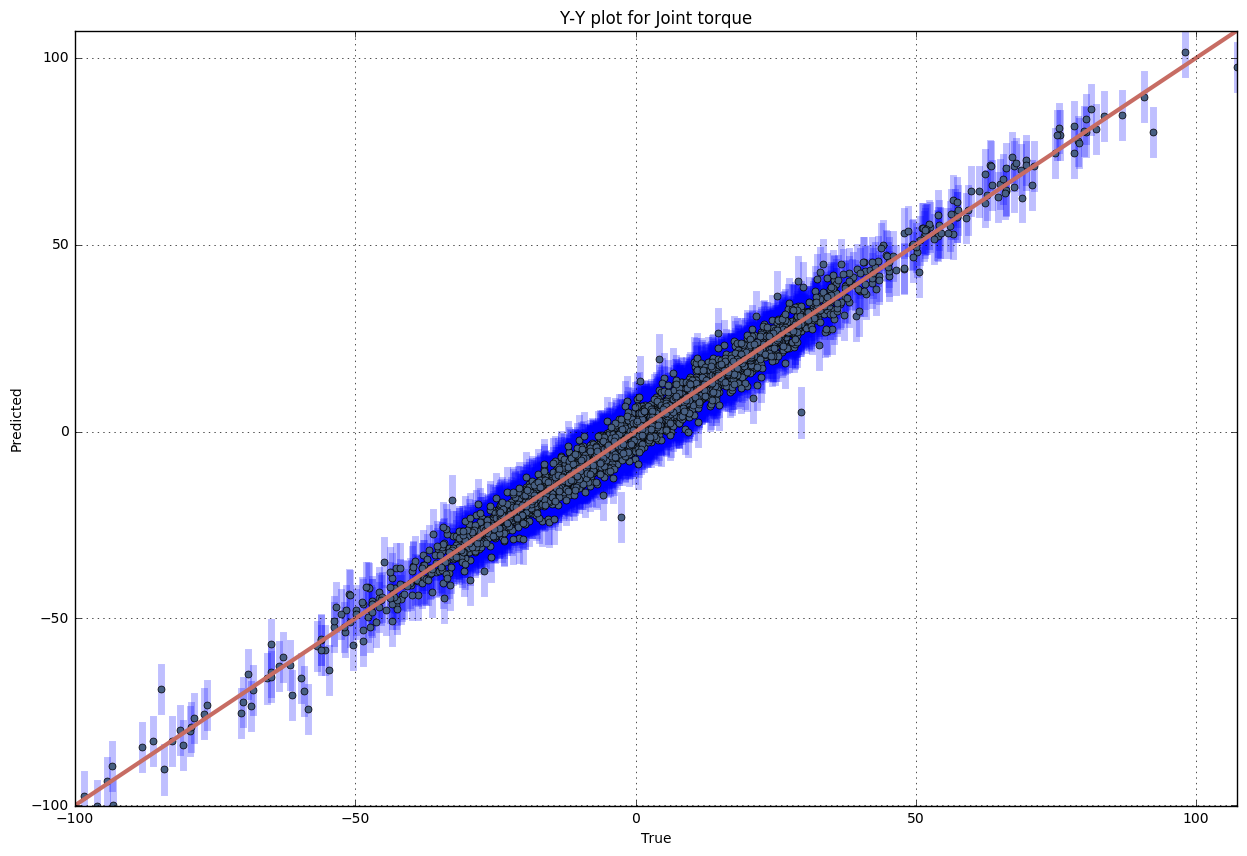

In [14]:
if not doGP:
    Ey, Vf = alg.predict_moments(X_test)
    Vy = Vf + alg.like_hypers_
    Sy = np.sqrt(Vy)
else:
    Ey, Sy = alg.predict(X_test, return_std=True)
    Vy = Sy**2

print("SMSE = {}".format(smse(y_test, Ey)))
print("MSLL = {}".format(msll(y_test, Ey, Vy, y_train)))

# YY plot
pl.figure(figsize=(15, 10))
fancy_yyplot(y_test, Ey, Ey - 2 * Sy, Ey + 2 * Sy, "Joint torque")